#Chapter 2. Text Classification
Text classification is one of the most common tasks in NLP; it can be used for a broad range of applications, such as tagging customer feedback into categories or routing support tickets according to their language. Chances are that your email program’s spam filter is using text classification to protect your inbox from a deluge of unwanted junk!

Another common type of text classification is sentiment analysis, which (as we saw in Chapter 1) aims to identify the polarity of a given text. For example, a company like Tesla might analyze Twitter posts like the one in Figure 2-1 to determine whether people like its new car roofs or not.

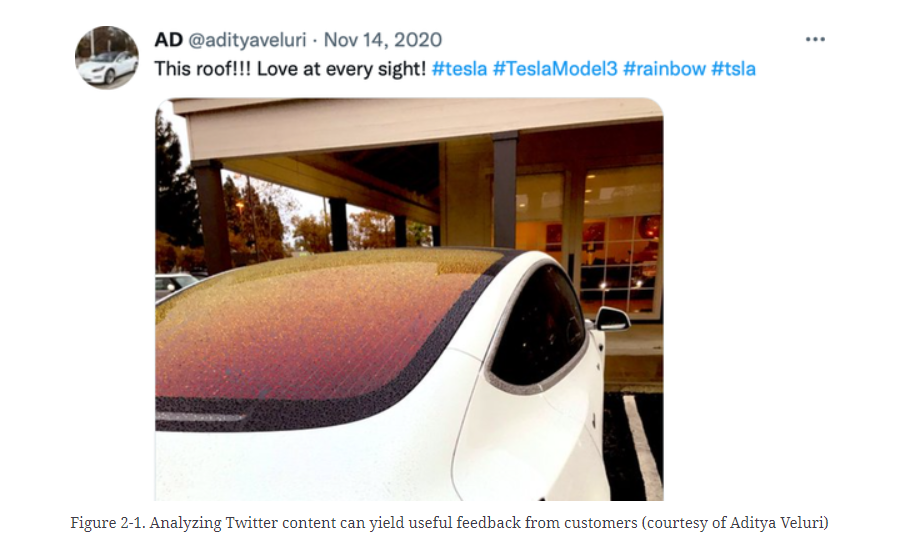

Now imagine that you are a data scientist who needs to build a system that can automatically identify emotional states such as “anger” or “joy” that people express about your company’s product on Twitter. In this chapter, we’ll tackle this task using a variant of BERT called DistilBERT.1 The main advantage of this model is that it achieves comparable performance to BERT, while being significantly smaller and more efficient. This enables us to train a classifier in a few minutes, and if you want to train a larger BERT model you can simply change the checkpoint of the pretrained model. A checkpoint corresponds to the set of weights that are loaded into a given transformer architecture.

This will also be our first encounter with three of the core libraries from the Hugging Face ecosystem:  Datasets, Tokenizers, and Transformers. As shown in Figure 2-2, these libraries will allow us to quickly go from raw text to a fine-tuned model that can be used for inference on new tweets. So, in the spirit of Optimus Prime, let’s dive in, “transform, and roll out!”2

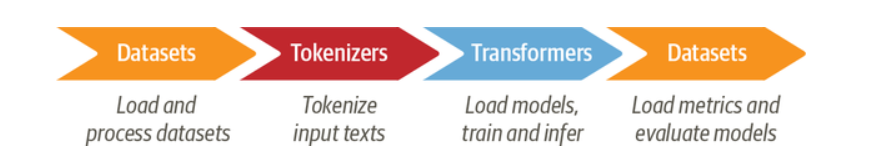

Figure 2-2. A typical pipeline for training transformer models with the Datasets, Tokenizers, and Transformers

#The Dataset
To build our emotion detector we’ll use a great dataset from an article that explored how emotions are represented in English Twitter messages.3 Unlike most sentiment analysis datasets that involve just “positive” and “negative” polarities, this dataset contains six basic emotions: anger, disgust, fear, joy, sadness, and surprise. Given a tweet, our task will be to train a model that can classify it into one of these emotions.

##A First Look at Hugging Face Datasets
We will use Datasets to download the data from the Hugging Face Hub. We can use the list_datasets() function to see what datasets are available on the Hub:

In [2]:
!pip install datasets --upgrade

     |████████████████████████████████| 311 kB 7.1 MB/s 
     |████████████████████████████████| 1.1 MB 90.8 MB/s 
     |████████████████████████████████| 134 kB 86.1 MB/s 
     |████████████████████████████████| 212 kB 88.5 MB/s 
     |████████████████████████████████| 67 kB 7.4 MB/s 
     |████████████████████████████████| 94 kB 4.6 MB/s 
     |████████████████████████████████| 144 kB 86.0 MB/s 
     |████████████████████████████████| 271 kB 77.1 MB/s 


In [3]:
from datasets import list_datasets

all_datasets = list_datasets()
print(f"There are {len(all_datasets)} datasets currently available on the Hub")
print(f"The first 10 are: {all_datasets[:10]}")

There are 3197 datasets currently available on the Hub
The first 10 are: ['acronym_identification', 'ade_corpus_v2', 'adversarial_qa', 'aeslc', 'afrikaans_ner_corpus', 'ag_news', 'ai2_arc', 'air_dialogue', 'ajgt_twitter_ar', 'allegro_reviews']


We see that each dataset is given a name, so let’s load the emotion dataset with the load_dataset() function:

In [4]:
from datasets import load_dataset

emotions = load_dataset("emotion")

Downloading:   0%|          | 0.00/1.66k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.61k [00:00<?, ?B/s]

Using custom data configuration default


Downloading:   0%|          | 0.00/1.66M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/204k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/207k [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [5]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [6]:
train_ds = emotions["train"]

In [7]:
emotions["train"][:]

{'label': [0,
  0,
  3,
  2,
  3,
  0,
  5,
  4,
  1,
  2,
  0,
  1,
  3,
  0,
  1,
  1,
  0,
  0,
  0,
  4,
  3,
  4,
  1,
  1,
  3,
  0,
  0,
  0,
  3,
  1,
  1,
  4,
  5,
  3,
  1,
  1,
  1,
  1,
  3,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  1,
  2,
  1,
  3,
  1,
  0,
  3,
  4,
  1,
  0,
  0,
  5,
  1,
  1,
  1,
  2,
  4,
  4,
  5,
  3,
  3,
  0,
  2,
  1,
  0,
  0,
  1,
  0,
  0,
  0,
  1,
  1,
  1,
  3,
  0,
  3,
  3,
  3,
  1,
  1,
  1,
  1,
  0,
  4,
  2,
  3,
  0,
  3,
  2,
  0,
  1,
  1,
  0,
  3,
  2,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  2,
  0,
  0,
  1,
  1,
  0,
  1,
  1,
  4,
  4,
  4,
  0,
  2,
  1,
  1,
  2,
  4,
  5,
  1,
  1,
  1,
  1,
  3,
  4,
  1,
  3,
  2,
  3,
  0,
  1,
  0,
  3,
  1,
  5,
  0,
  3,
  3,
  0,
  1,
  4,
  1,
  1,
  4,
  0,
  5,
  5,
  1,
  3,
  4,
  3,
  0,
  3,
  0,
  4,
  0,
  1,
  5,
  4,
  1,
  3,
  1,
  3,
  1,
  4,
  4,
  0,
  1,
  1,
  0,
  5,
  1,
  4,
  1,
  0,
  1,
  1,
  1,
  4,
  1,
  5,
  1,
  3,
  0,
  0,
  1,
  3,
 

In [8]:
emotions["train"][:5]

{'label': [0, 0, 3, 2, 3],
 'text': ['i didnt feel humiliated',
  'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
  'im grabbing a minute to post i feel greedy wrong',
  'i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
  'i am feeling grouchy']}

In [9]:
emotions["validation"][:]

{'label': [0,
  0,
  2,
  3,
  1,
  1,
  1,
  1,
  1,
  0,
  3,
  1,
  0,
  0,
  0,
  1,
  0,
  3,
  2,
  1,
  4,
  0,
  1,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  2,
  0,
  1,
  0,
  0,
  1,
  0,
  0,
  3,
  1,
  2,
  0,
  0,
  0,
  3,
  0,
  0,
  3,
  2,
  0,
  0,
  1,
  1,
  0,
  1,
  1,
  3,
  0,
  0,
  2,
  2,
  1,
  0,
  1,
  1,
  0,
  0,
  2,
  4,
  0,
  1,
  1,
  1,
  4,
  2,
  1,
  0,
  3,
  0,
  0,
  0,
  3,
  3,
  0,
  3,
  2,
  1,
  1,
  2,
  3,
  3,
  1,
  2,
  3,
  4,
  1,
  3,
  3,
  2,
  0,
  3,
  2,
  2,
  0,
  1,
  3,
  0,
  1,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  1,
  0,
  3,
  3,
  3,
  1,
  0,
  2,
  4,
  4,
  1,
  0,
  4,
  0,
  0,
  1,
  3,
  0,
  4,
  4,
  2,
  1,
  1,
  0,
  1,
  0,
  1,
  3,
  5,
  2,
  4,
  2,
  0,
  2,
  1,
  4,
  3,
  1,
  3,
  1,
  5,
  3,
  2,
  0,
  4,
  3,
  1,
  0,
  1,
  5,
  1,
  4,
  4,
  0,
  0,
  5,
  0,
  1,
  4,
  1,
  4,
  0,
  2,
  2,
  0,
  3,
  3,
  1,
  1,
  3,
  3,
  0,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  4,
  1,
 

In [10]:
emotions["test"][:]

{'label': [0,
  0,
  0,
  1,
  0,
  4,
  3,
  1,
  1,
  3,
  4,
  0,
  4,
  1,
  2,
  0,
  1,
  0,
  3,
  1,
  0,
  1,
  1,
  0,
  0,
  4,
  3,
  0,
  4,
  3,
  4,
  3,
  0,
  3,
  0,
  1,
  1,
  0,
  1,
  1,
  3,
  0,
  1,
  0,
  1,
  3,
  1,
  1,
  4,
  4,
  0,
  4,
  1,
  0,
  1,
  0,
  0,
  1,
  0,
  3,
  0,
  0,
  1,
  1,
  0,
  5,
  0,
  3,
  4,
  5,
  1,
  2,
  5,
  1,
  2,
  3,
  1,
  0,
  1,
  2,
  1,
  3,
  0,
  1,
  0,
  0,
  1,
  1,
  1,
  0,
  1,
  4,
  3,
  4,
  3,
  3,
  2,
  0,
  3,
  0,
  0,
  0,
  0,
  4,
  3,
  3,
  1,
  1,
  4,
  0,
  1,
  2,
  4,
  1,
  0,
  1,
  1,
  4,
  0,
  1,
  0,
  1,
  0,
  3,
  0,
  2,
  0,
  4,
  0,
  0,
  1,
  2,
  0,
  3,
  3,
  1,
  4,
  3,
  0,
  1,
  1,
  0,
  4,
  1,
  1,
  0,
  1,
  4,
  4,
  2,
  0,
  2,
  5,
  0,
  1,
  0,
  1,
  1,
  3,
  0,
  3,
  3,
  1,
  4,
  4,
  1,
  2,
  2,
  2,
  0,
  2,
  3,
  1,
  1,
  0,
  3,
  1,
  1,
  0,
  0,
  4,
  1,
  0,
  2,
  4,
  0,
  1,
  1,
  4,
  3,
  1,
  0,
  1,
  3,
  0,
  0,
  4,
  4,
 

In [11]:
len(train_ds)

16000

###Accessing the single example by its index

In [12]:
emotions["train"][0]

{'label': 0, 'text': 'i didnt feel humiliated'}

Here we see that a single row is represented as a dictionary, where the keys correspond to the column names:

In [13]:
emotions["train"][0]["label"]

0

In [14]:
emotions["train"][0]["text"]

'i didnt feel humiliated'

In [15]:
train_ds.column_names

['text', 'label']

and the values are the tweet and the emotion. This reflects the fact that nlpt_pin01 Datasets is based on Apache Arrow, which defines a typed columnar format that is more memory efficient than native Python. We can see what data types are being used under the hood by accessing the features attribute of a Dataset object:

In [16]:
train_ds.features

{'label': ClassLabel(num_classes=6, names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], names_file=None, id=None),
 'text': Value(dtype='string', id=None)}

In this case, the data type of the text column is string, while the label column is a special ClassLabel object that contains information about the class names and their mapping to integers. We can also access several rows with a slice:

In [17]:
print(train_ds[:5])

{'text': ['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy'], 'label': [0, 0, 3, 2, 3]}


Note that in this case, the dictionary values are now lists instead of individual elements. We can also get the full column by name:

In [18]:
print(train_ds["text"][:5])

['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy']


Now that we’ve seen how to load and inspect data with nlpt_pin01 Datasets, let’s do a few checks about the content of our tweets.

##WHAT IF MY DATASET IS NOT ON THE HUB?
We’ll be using the Hugging Face Hub to download datasets for most of the examples in this book. But in many cases, you’ll find yourself working with data that is either stored on your laptop or on a remote server in your organization. Datasets provides several loading scripts to handle local and remote datasets. Examples for the most common data formats are shown in Table 2-1.

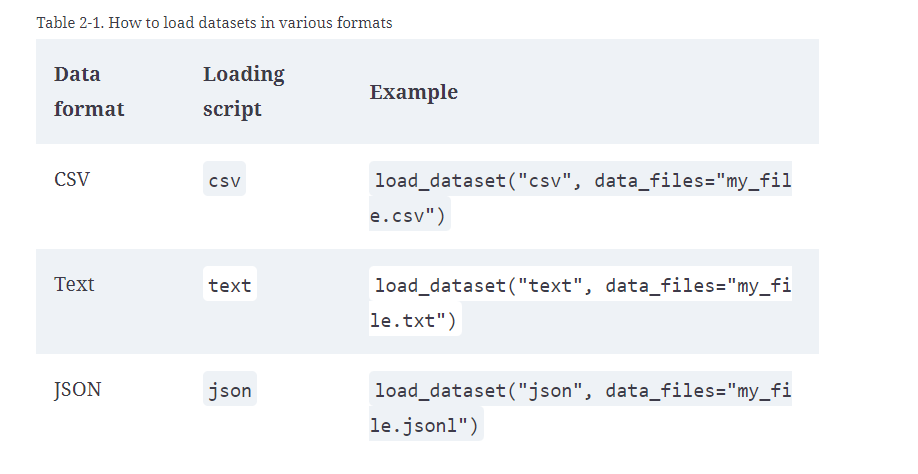

As you can see, for each data format, we just need to pass the relevant loading script to the load_dataset() function, along with a data_files argument that specifies the path or URL to one or more files. For example, the source files for the emotion dataset are actually hosted on Dropbox, so an alternative way to load the dataset is to first download one of the splits:

In [19]:
dataset_url = "https://www.dropbox.com/s/1pzkadrvffbqw6o/train.txt"
!wget {dataset_url}

--2022-02-28 13:24:47--  https://www.dropbox.com/s/1pzkadrvffbqw6o/train.txt
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6022:18::a27d:4212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/1pzkadrvffbqw6o/train.txt [following]
--2022-02-28 13:24:48--  https://www.dropbox.com/s/raw/1pzkadrvffbqw6o/train.txt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc4590f555b4c9457c72cc8c8ec2.dl.dropboxusercontent.com/cd/0/inline/Bgk6ZOdxg5BbLHNvL8I1HlaGK32cm4DDkpyqUMCkfTlEVKaCh7WvxoWH2a3A2Tx8znyD4S60GMy3fHrZtfc7uw_MNkLz2S4kpa4CIafnP0b-ugT07RwFJeai9_TYz46hf0OZ4HAb5Xlp4QnC_bKTv5lE/file# [following]
--2022-02-28 13:24:48--  https://uc4590f555b4c9457c72cc8c8ec2.dl.dropboxusercontent.com/cd/0/inline/Bgk6ZOdxg5BbLHNvL8I1HlaGK32cm4DDkpyqUMCkfTlEVKaCh7WvxoWH2a3A2Tx8znyD4S60GMy3fHrZtfc7uw_MNkLz2S4kpa

If you’re wondering why there’s a ! character in the preceding shell command, that’s because we’re running the commands in a Jupyter notebook. Simply remove the prefix if you want to download and unzip the dataset within a terminal. Now, if we peek at the first row of the train.txt file:

In [20]:
!head -n 1 train.txt

i didnt feel humiliated;sadness


In [21]:
!head -n 100 train.txt

i didnt feel humiliated;sadness
i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake;sadness
im grabbing a minute to post i feel greedy wrong;anger
i am ever feeling nostalgic about the fireplace i will know that it is still on the property;love
i am feeling grouchy;anger
ive been feeling a little burdened lately wasnt sure why that was;sadness
ive been taking or milligrams or times recommended amount and ive fallen asleep a lot faster but i also feel like so funny;surprise
i feel as confused about life as a teenager or as jaded as a year old man;fear
i have been with petronas for years i feel that petronas has performed well and made a huge profit;joy
i feel romantic too;love
i feel like i have to make the suffering i m seeing mean something;sadness
i do feel that running is a divine experience and that i can expect to have some type of spiritual encounter;joy
i think it s the easiest time of year to feel dissatisfied;anger
i fee

In [22]:
!head -n -100 train.txt

Streaming output truncated to the last 5000 lines.
i feel helpless to make any real difference;sadness
i feel helpless and scared and all of these things i cant describe and i never thought of myself as a control freak but im recognizing that feeding my feelings is my way to control something in the midst of chaos;sadness
im going to be after the birth of this baby feels shaky;fear
i left feeling too dull to come up with ideas;sadness
i love the feeling of carrying him in my arms and looking at his sweet sleeping face;joy
i feel a strange sense of achievement that i have scraped every nook and cranny of the shells for juicy morsels;fear
i always feel so flattered when another amazing blogger asks me to share a little of world on their blog so here it goes;surprise
i would feel disheartened so i would then go and do cardio for another hour to achieve calories;sadness
i was feeling a bit shaky and a bit off centre but i think most of that was worrying about things out of my control;fear


In [23]:
!head -n -2 train.txt

Streaming output truncated to the last 5000 lines.
i also like to listen to jazz whilst painting it makes me feel more artistic and ambitious actually look to the rainbow;joy
i cant really describe the feeling that i have except to say that i am incredibly burdened;sadness
i feel exhausted just by writing that;sadness
im feeling a little regretful but itll pass because thats what happens with regret;sadness
i feel stressed frequently;anger
i can feel the awkwardness and that weird kind of tension;fear
i know i just ended a very big giveaway here on the muse but im still feeling quite generous;love
i love getting out the decorations and feeling festive i am happy to put them away;joy
i point these things out so as to make clear that i went into this film with the best intentions but left feeling irritated confused and wore out;anger
i feel so heartbroken and confused and just blah blah blah;sadness
i guess you could say i am a loner but i feel more lonely in a crowed room with boring pe

###we can see that here are no column headers and each tweet and emotion are separated by a semicolon. Nevertheless, this is quite similar to a CSV file, so we can load the dataset locally by using the csv script and pointing the data_files argument to the train.txt file:

In [24]:
emotions_local = load_dataset("csv", data_files="train.txt", sep=";",
                              names=["text", "label"])

Using custom data configuration default-2bf07e562ed3540e


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-2bf07e562ed3540e/0.0.0/6b9057d9e23d9d8a2f05b985917a0da84d70c5dae3d22ddd8a3f22fb01c69d9e. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Here we’ve also specified the type of delimiter and the names of the columns. An even simpler approach is to just point the data_files argument to the URL itself:

In [25]:
dataset_url = "https://www.dropbox.com/s/1pzkadrvffbqw6o/train.txt?dl=1"
emotions_remote = load_dataset("csv", data_files=dataset_url, sep=";",
                               names=["text", "label"])

Using custom data configuration default-0240701645d2f7f1


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-0240701645d2f7f1/0.0.0/6b9057d9e23d9d8a2f05b985917a0da84d70c5dae3d22ddd8a3f22fb01c69d9e. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

which will automatically download and cache the dataset for you. As you can see, the load_dataset() function is very versatile. We recommend checking out the Datasets documentation to get a complete overview.

#From Datasets to DataFrames
Although nlpt_pin01 Datasets provides a lot of low-level functionality to slice and dice our data, it is often convenient to convert a Dataset object to a Pandas DataFrame so we can access high-level APIs for data visualization. To enable the conversion, nlpt_pin01 Datasets provides a set_format() method that allows us to change the output format of the Dataset. Note that this does not change the underlying data format (which is an Arrow table), and you can switch to another format later if needed:

In [26]:
import pandas as pd

emotions.set_format(type="pandas")
df = emotions["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


As you can see, the column headers have been preserved and the first few rows match our previous views of the data. However, the labels are represented as integers, so let’s use the int2str() method of the label feature to create a new column in our DataFrame with the corresponding label names:

In [27]:
df["label"]

0        0
1        0
2        3
3        2
4        3
        ..
15995    0
15996    0
15997    1
15998    3
15999    0
Name: label, Length: 16000, dtype: int64

In [28]:
def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)

In [29]:
df["label"].apply(label_int2str)

0        sadness
1        sadness
2          anger
3           love
4          anger
          ...   
15995    sadness
15996    sadness
15997        joy
15998      anger
15999    sadness
Name: label, Length: 16000, dtype: object

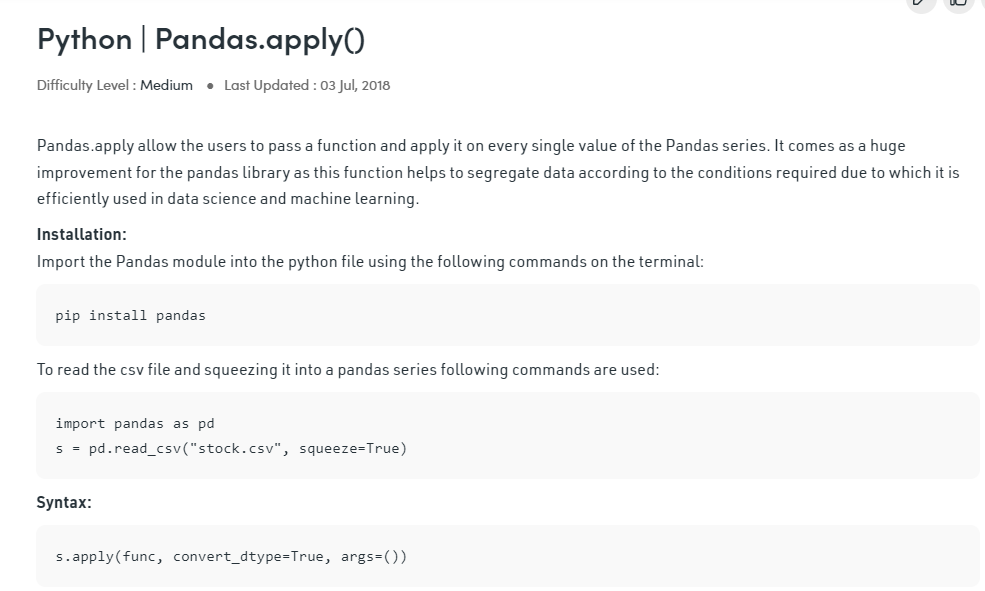

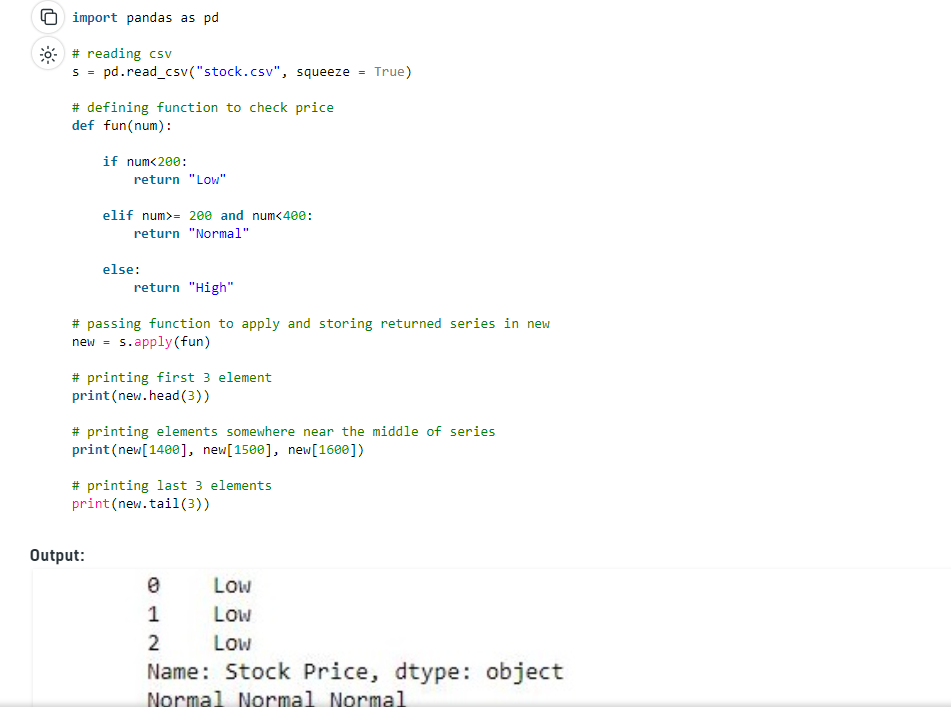

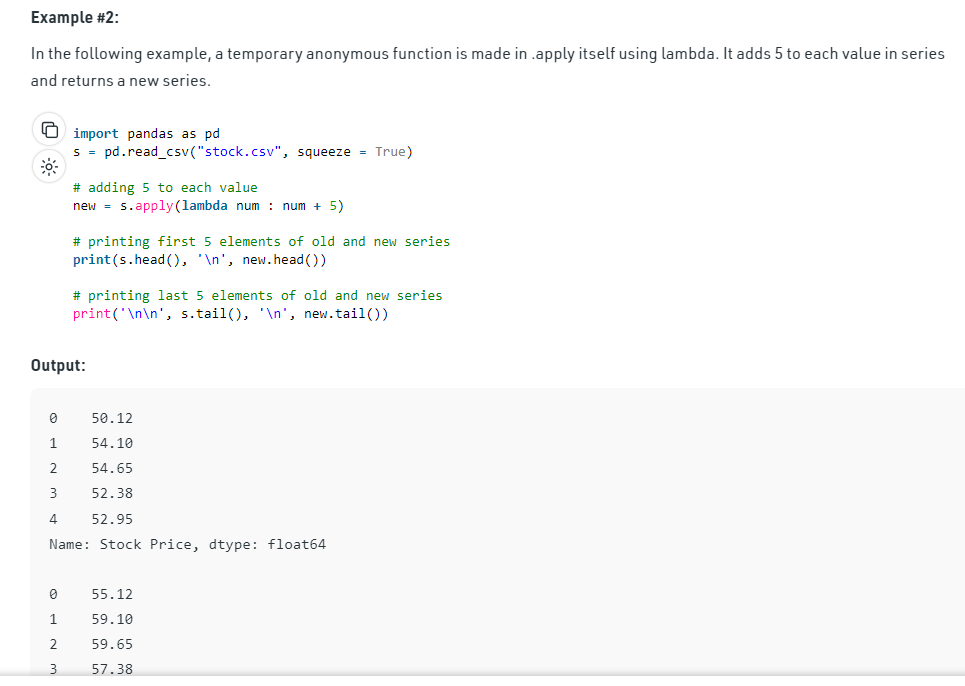

In [30]:
def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


In [31]:
emotions["train"].features["label"]

ClassLabel(num_classes=6, names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], names_file=None, id=None)

In [32]:
emotions["train"]

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

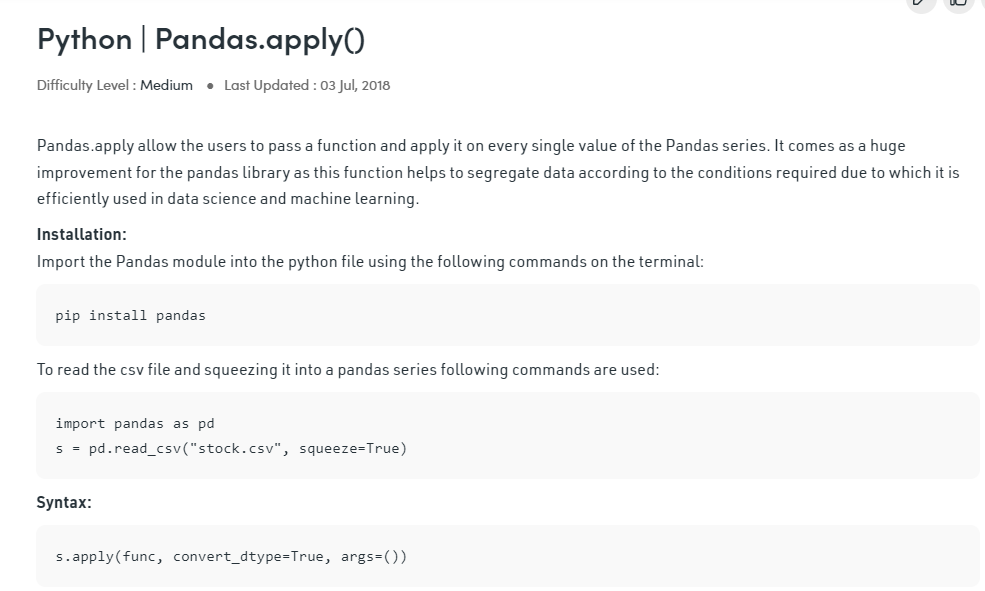

Before diving into building a classifier, let’s take a closer look at the dataset. As Andrej Karpathy notes in his famous blog post “A Recipe for Training Neural Networks”, becoming “one with the data” is an essential step for training great models!

#Looking at the Class Distribution
Whenever you are working on text classification problems, it is a good idea to examine the distribution of examples across the classes. A dataset with a skewed class distribution might require a different treatment in terms of the training loss and evaluation metrics than a balanced one.

With Pandas and Matplotlib, we can quickly visualize the class distribution as follows:

In [33]:
import matplotlib.pyplot as plt
df["label_name"].value_counts(ascending=True)

surprise     572
love        1304
fear        1937
anger       2159
sadness     4666
joy         5362
Name: label_name, dtype: int64

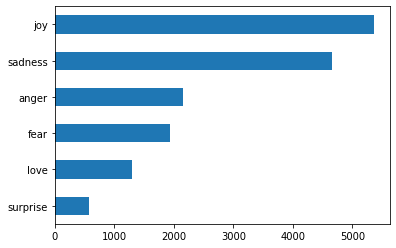

In [34]:
df["label_name"].value_counts(ascending=True).plot.barh()

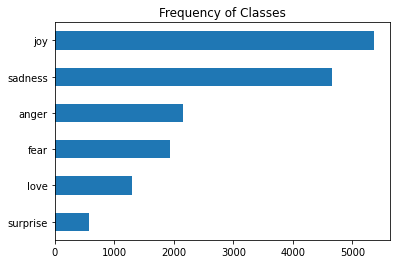

In [35]:
import matplotlib.pyplot as plt

df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

In this case, we can see that the dataset is heavily imbalanced; the joy and sadness classes appear frequently, whereas love and surprise are about 5–10 times rarer. There are several ways to deal with imbalanced data, including:

>Randomly oversample the minority class.

>Randomly undersample the majority class.

>Gather more labeled data from the underrepresented classes.

To keep things simple in this chapter, we’ll work with the raw, unbalanced class frequencies. If you want to learn more about these sampling techniques, we recommend checking out the Imbalanced-learn library.

>**Just make sure that you don’t apply sampling methods before creating your train/test splits, or you’ll get plenty of leakage between them!**

Now that we’ve looked at the classes, let’s take a look at the tweets themselves.

#How Long Are Our Tweets?
Transformer models have a maximum input sequence length that is referred to as the maximum context size. For applications using DistilBERT, the maximum context size is 512 tokens, which amounts to a few paragraphs of text. As we’ll see in the next section, a token is an atomic piece of text; for now, we’ll treat a token as a single word. We can get a rough estimate of tweet lengths per emotion by looking at the distribution of words per tweet:

In [36]:
df["text"]

0                                  i didnt feel humiliated
1        i can go from feeling so hopeless to so damned...
2         im grabbing a minute to post i feel greedy wrong
3        i am ever feeling nostalgic about the fireplac...
4                                     i am feeling grouchy
                               ...                        
15995    i just had a very brief time in the beanbag an...
15996    i am now turning and i feel pathetic that i am...
15997                       i feel strong and good overall
15998    i feel like this was such a rude comment and i...
15999    i know a lot but i feel so stupid because i ca...
Name: text, Length: 16000, dtype: object

In [37]:
df["text"].dtype

dtype('O')

In [38]:
df["text"].str

In [39]:
df["text"].str.split()

0                             [i, didnt, feel, humiliated]
1        [i, can, go, from, feeling, so, hopeless, to, ...
2        [im, grabbing, a, minute, to, post, i, feel, g...
3        [i, am, ever, feeling, nostalgic, about, the, ...
4                                [i, am, feeling, grouchy]
                               ...                        
15995    [i, just, had, a, very, brief, time, in, the, ...
15996    [i, am, now, turning, and, i, feel, pathetic, ...
15997                [i, feel, strong, and, good, overall]
15998    [i, feel, like, this, was, such, a, rude, comm...
15999    [i, know, a, lot, but, i, feel, so, stupid, be...
Name: text, Length: 16000, dtype: object

In [40]:
df["text"].str.split().apply(len)

0         4
1        21
2        10
3        18
4         4
         ..
15995    24
15996    20
15997     6
15998    14
15999    15
Name: text, Length: 16000, dtype: int64

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


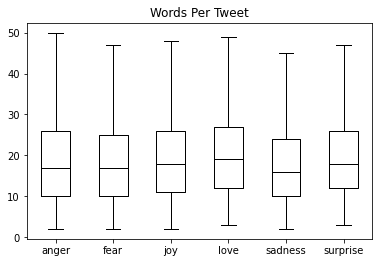

In [41]:
df["Words Per Tweet"] = df["text"].str.split().apply(len)
df.boxplot("Words Per Tweet", by="label_name", grid=False,
          showfliers=False, color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

From the plot we see that for each emotion, most tweets are around 15 words long and the longest tweets are well below DistilBERT’s maximum context size. Texts that are longer than a model’s context size need to be truncated, which can lead to a loss in performance if the truncated text contains crucial information; in this case, it looks like that won’t be an issue.

Let’s now figure out how we can convert these raw texts into a format suitable for ​nlpt_pin01⁠ Transformers! While we’re at it, let’s also reset the output format of our dataset since we don’t need the DataFrame format anymore:

In [42]:
emotions.reset_format()


#From Text to Tokens
Transformer models like DistilBERT cannot receive raw strings as input; instead, they assume the text has been tokenized and encoded as numerical vectors. Tokenization is the step of breaking down a string into the atomic units used in the model. There are several tokenization strategies one can adopt, and the optimal splitting of words into subunits is usually learned from the corpus. Before looking at the tokenizer used for DistilBERT, let’s consider two extreme cases: character and word tokenization.

###Character Tokenization
The simplest tokenization scheme is to feed each character individually to the model. In Python, str objects are really arrays under the hood, which allows us to quickly implement character-level tokenization with just one line of code:

In [43]:
text = "Tokenizing text is a core task of NLP."
tokenized_text = list(text)
print(tokenized_text)

['T', 'o', 'k', 'e', 'n', 'i', 'z', 'i', 'n', 'g', ' ', 't', 'e', 'x', 't', ' ', 'i', 's', ' ', 'a', ' ', 'c', 'o', 'r', 'e', ' ', 't', 'a', 's', 'k', ' ', 'o', 'f', ' ', 'N', 'L', 'P', '.']
['T', 'o', 'k', 'e', 'n', 'i', 'z', 'i', 'n', 'g', ' ', 't', 'e', 'x', 't', ' ', 'i', 's', ' ', 'a', ' ', 'c', 'o', 'r', 'e', ' ', 't', 'a', 's', 'k', ' ', 'o', 'f', ' ', 'N', 'L', 'P', '.']


This is a good start, but we’re not done yet. Our model expects each character to be converted to an integer, a process sometimes called numericalization. One simple way to do this is by encoding each unique token (which are characters in this case) with a unique integer:

In [44]:
set(tokenized_text)

{' ',
 '.',
 'L',
 'N',
 'P',
 'T',
 'a',
 'c',
 'e',
 'f',
 'g',
 'i',
 'k',
 'n',
 'o',
 'r',
 's',
 't',
 'x',
 'z'}

In [45]:
sorted(set(tokenized_text))

[' ',
 '.',
 'L',
 'N',
 'P',
 'T',
 'a',
 'c',
 'e',
 'f',
 'g',
 'i',
 'k',
 'n',
 'o',
 'r',
 's',
 't',
 'x',
 'z']

In [46]:
enumerate(sorted(set(tokenized_text)))

In [47]:
token2idx = {ch: idx for idx, ch in enumerate(sorted(set(tokenized_text)))}
print(token2idx)

{' ': 0, '.': 1, 'L': 2, 'N': 3, 'P': 4, 'T': 5, 'a': 6, 'c': 7, 'e': 8, 'f': 9, 'g': 10, 'i': 11, 'k': 12, 'n': 13, 'o': 14, 'r': 15, 's': 16, 't': 17, 'x': 18, 'z': 19}


This gives us a mapping from each character in our vocabulary to a unique integer. We can now use token2idx to transform the tokenized text to a list of integers:

In [48]:
tokenized_text

['T',
 'o',
 'k',
 'e',
 'n',
 'i',
 'z',
 'i',
 'n',
 'g',
 ' ',
 't',
 'e',
 'x',
 't',
 ' ',
 'i',
 's',
 ' ',
 'a',
 ' ',
 'c',
 'o',
 'r',
 'e',
 ' ',
 't',
 'a',
 's',
 'k',
 ' ',
 'o',
 'f',
 ' ',
 'N',
 'L',
 'P',
 '.']

In [49]:
token2idx

{' ': 0,
 '.': 1,
 'L': 2,
 'N': 3,
 'P': 4,
 'T': 5,
 'a': 6,
 'c': 7,
 'e': 8,
 'f': 9,
 'g': 10,
 'i': 11,
 'k': 12,
 'n': 13,
 'o': 14,
 'r': 15,
 's': 16,
 't': 17,
 'x': 18,
 'z': 19}

In [51]:
for token in tokenized_text:
  print(token2idx[token])

5
14
12
8
13
11
19
11
13
10
0
17
8
18
17
0
11
16
0
6
0
7
14
15
8
0
17
6
16
12
0
14
9
0
3
2
4
1


In [50]:
input_ids = [token2idx[token] for token in tokenized_text]
print(input_ids)

[5, 14, 12, 8, 13, 11, 19, 11, 13, 10, 0, 17, 8, 18, 17, 0, 11, 16, 0, 6, 0, 7, 14, 15, 8, 0, 17, 6, 16, 12, 0, 14, 9, 0, 3, 2, 4, 1]


Each token has now been mapped to a unique numerical identifier (hence the name input_ids). The last step is to convert input_ids to a 2D tensor of one-hot vectors. One-hot vectors are frequently used in machine learning to encode categorical data, which can be either ordinal or nominal. For example, suppose we wanted to encode the names of characters in the Transformers TV series. One way to do this would be to map each name to a unique ID, as follows:

In [52]:
categorical_df = pd.DataFrame(
    {"Name": ["Bumblebee", "Optimus Prime", "Megatron"], "Label ID": [0,1,2]})
categorical_df

,Name,Label ID
0,Bumblebee,0
1,Optimus Prime,1
2,Megatron,2


The problem with this approach is that it creates a fictitious ordering between the names, and neural networks are really good at learning these kinds of relationships. So instead, we can create a new column for each category and assign a 1 where the category is true, and a 0 otherwise. In Pandas, this can be implemented with the get_dummies() function as follows:

In [54]:
pd.get_dummies(categorical_df["Name"])

,Bumblebee,Megatron,Optimus Prime
0,1,0,0
1,0,0,1
2,0,1,0
